## The Problem of the Travelling Salesperson

# Numerical simulation

### Imports

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose # main lib used in this study for implementing simulated annealing
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import time
import pandas as pd
from geopy import distance
import folium

### Settings

In [2]:
sns.set_theme() # Using seaborn as the default plotting
sns.set_palette("pastel") # Setting the paletter for seaborn
logging.basicConfig(level=logging.INFO) # Setting logging for program

In [3]:
def generate_random_nodes(x_min: int, y_min: int, x_max: int, y_max: int, num_nodes: int, seed: int):
    np.random.seed(seed) # Setting the seed value for reproducibility
    x_coords = np.random.uniform(x_min, x_max, num_nodes)
    y_coords = np.random.uniform(y_min, y_max, num_nodes)
    nodes = np.column_stack((x_coords, y_coords))
    return nodes, x_coords, y_coords


def plot_results(best_result_df, x_coords, y_coords):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(f"Best results for {best_result_df['Nodes'][0]} cities")
    axs[0].set_title(f"Best Route using Simulated Annealing")
    axs[1].set_title(f"Fitness Curve")
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[1].set_xlabel('Iterations')
    axs[1].set_ylabel('Distance')
    fig.set_size_inches(16, 8)
    coords_loop = best_result_df['Route'][0].copy()
    coords_loop.append(best_result_df['Route'][0][0])
    coords_loop = np.stack(coords_loop)
    x_coords, y_coords = np.hsplit(coords_loop, 2)
    axs[0].plot(x_coords, y_coords, 'm*')
    axs[0].plot(x_coords, y_coords, 'c')
    axs[0].text(5, 5.5, f"Best distance: \n {best_result_df['FinalDistance'][0]}", bbox=dict(boxstyle='square', facecolor='lime'))
    x = [i+1 for i in range(len(best_result_df['FitnessCurve'][0]))]
    axs[1].plot(x, np.absolute(best_result_df['FitnessCurve'][0]))
    plt.savefig(f"../data/output_graphs/result_{best_result_df['Nodes'][0]}_{int(time.time())}.png")


def load_data(filename):
    df = pd.read_csv(f"../data/{filename}", usecols=['city', 'lat', 'lng'])[:10]
    lats = df['lat'].values
    longs = df['lng'].values
    nodes = np.column_stack((lats, longs))
    labels = df['city'].values
    return df, nodes, labels


def calc_geodesic_distances(nodes):
    distances = []
    for i in range(len(nodes)-1):
        for j in range(i+1, len(nodes)):
            dist = round(distance.distance(nodes[i], nodes[j]).km, 4) 
            _tup = (i, j, dist)
            distances.append(_tup)
    return distances


def calc_distances(coords):
    distances = []
    for i in range(len(coords)-1):
        for j in range(i+1, len(coords)):
            dist = round(math.dist(coords[i], coords[j]), 4)
            _tup = (i, j, dist)
            distances.append(_tup)
    return distances


def set_schedules():
    schedules = {'a_0001': mlrose.ArithDecay(decay=0.0001),
            'a_001': mlrose.ArithDecay(decay=0.001),
            'a_01': mlrose.ArithDecay(decay=0.01),
            'g_99': mlrose.GeomDecay(decay=0.99),
            'g_95': mlrose.GeomDecay(decay=0.95),
            'g_90': mlrose.GeomDecay(decay=0.90),
            'e_005': mlrose.ExpDecay(exp_const=0.005),
            'e_01': mlrose.ExpDecay(exp_const=0.01),
            'e_05': mlrose.ExpDecay(exp_const=0.05)}
    return schedules


def find_optimal_route(city_size, nodes, problem_fit, schedules, save=True):
    results = {'Nodes': [],
            'Map': [],
            'NumIters': [],
            'DecaySchedule': [],
            'ProcessingTime': [],
            'FinalDistance': [],
            'FitnessCurve': [],
            'Route': []}
    for j, schedule in enumerate(schedules):
        start_time = time.perf_counter()
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(problem_fit, schedules[schedule], curve=True)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        route = [nodes[best_state[k]] for k in range(len(best_state))]
        results['Nodes'].append(city_size)
        results['Map'].append(nodes)
        results['NumIters'].append(len(fitness_curve))
        results['DecaySchedule'].append(schedule)
        results['ProcessingTime'].append(f'{run_time:.5f}')
        results['FinalDistance'].append(best_fitness)
        results['FitnessCurve'].append(fitness_curve)
        results['Route'].append(route)
    results_df = pd.DataFrame(results)
    if save:
        results_df.to_csv(f"../data/output_data/results_{city_size}_{int(time.time())}.csv")
    return results_df


def get_best_route(za_df, za_results_df, best_decay_schedule):
    best_route = list(za_results_df[za_results_df['DecaySchedule'] == best_decay_schedule]['Route'])[0]
    coords_loop = best_route.copy()
    coords_loop.append(coords_loop[0])
    coords_loop = np.stack(coords_loop)
    _lats, _longs = np.hsplit(coords_loop, 2)
    _lats = [item for sublist in _lats for item in sublist]
    _longs = [item for sublist in _longs for item in sublist]
    route_df = pd.DataFrame({'lat': list(_lats),
    'lng': list(_longs)})
    city_order = []
    for index, row in route_df.iterrows():
        city = za_df[za_df['lat'] == coords_loop[index][0]]['city'].values[0]
        city_order.append(city)
    route_df['city'] = city_order
    return route_df, coords_loop


def filter_results(results_df):
    _df_filter_one = results_df[results_df['FinalDistance'] == results_df['FinalDistance'].min()]
    _df_filter_two = _df_filter_one[_df_filter_one['NumIters'] == _df_filter_one['NumIters'].min()]
    filtered_results = _df_filter_two[_df_filter_two['ProcessingTime'] == _df_filter_two['ProcessingTime'].min()].reset_index(drop=True)
    return filtered_results


def simulate_tsp(city_sizes, num_sims, show=False):
    schedules = set_schedules()
    best_results = pd.DataFrame()
    raw_results = pd.DataFrame()
    seeds = [i*3 for i in range(num_sims)]
    for i in range(num_sims):
        for city_size in city_sizes:
            nodes, x_coords, y_coords = generate_random_nodes(0, 0, 100, 100, city_size, seeds[i])
            distances = calc_distances(nodes)
            fitness_dists = mlrose.TravellingSales(distances = distances)
            problem_fit = mlrose.TSPOpt(length = len(nodes), fitness_fn = fitness_dists, maximize=False)
            results_df = find_optimal_route(city_size, nodes, problem_fit, schedules, show)
            best_result_df = filter_results(results_df)
            best_results = pd.concat([best_results, best_result_df])
            if show:
                plot_results(best_result_df, x_coords, y_coords)
                raw_results = pd.concat([raw_results, results_df])
    averaged_results = best_results.groupby(['Nodes', 'DecaySchedule']).mean()[['NumIters', 'FinalDistance']].sort_values(by=['FinalDistance'])
    return raw_results, averaged_results


def plot_real_map_route(route_df, coords_loop):
    plt.rcParams["figure.figsize"]=10,12
    m = folium.Map(location=[-28, 25], zoom_start=6)
    for index, row in route_df.iterrows():
        folium.CircleMarker([route_df['lat'][index], route_df['lng'][index]]).add_to(m)
    folium.PolyLine(coords_loop, color="red").add_to(m)
    m.save("../data/output_graphs/result_real_map.html")
    return m


def simulate_tsp_real_map(num_sims, filename):
    schedules = set_schedules()
    best_results = pd.DataFrame()
    _df, nodes, labels = load_data(filename)
    distances = calc_geodesic_distances(nodes)
    fitness_dists = mlrose.TravellingSales(distances = distances)
    problem_fit = mlrose.TSPOpt(length = len(nodes), fitness_fn = fitness_dists, maximize=False)
    for i in range(num_sims):
        results_df = find_optimal_route(len(nodes), nodes, problem_fit, schedules)
        best_result_df = filter_results(results_df)
        best_results = pd.concat([best_results, best_result_df])
    averaged_results = best_results.groupby(['Nodes', 'DecaySchedule']).mean()[['NumIters', 'FinalDistance']].sort_values(by=['FinalDistance'])
    return _df, results_df, averaged_results

Show how the algorithm works on different sizes of cities:

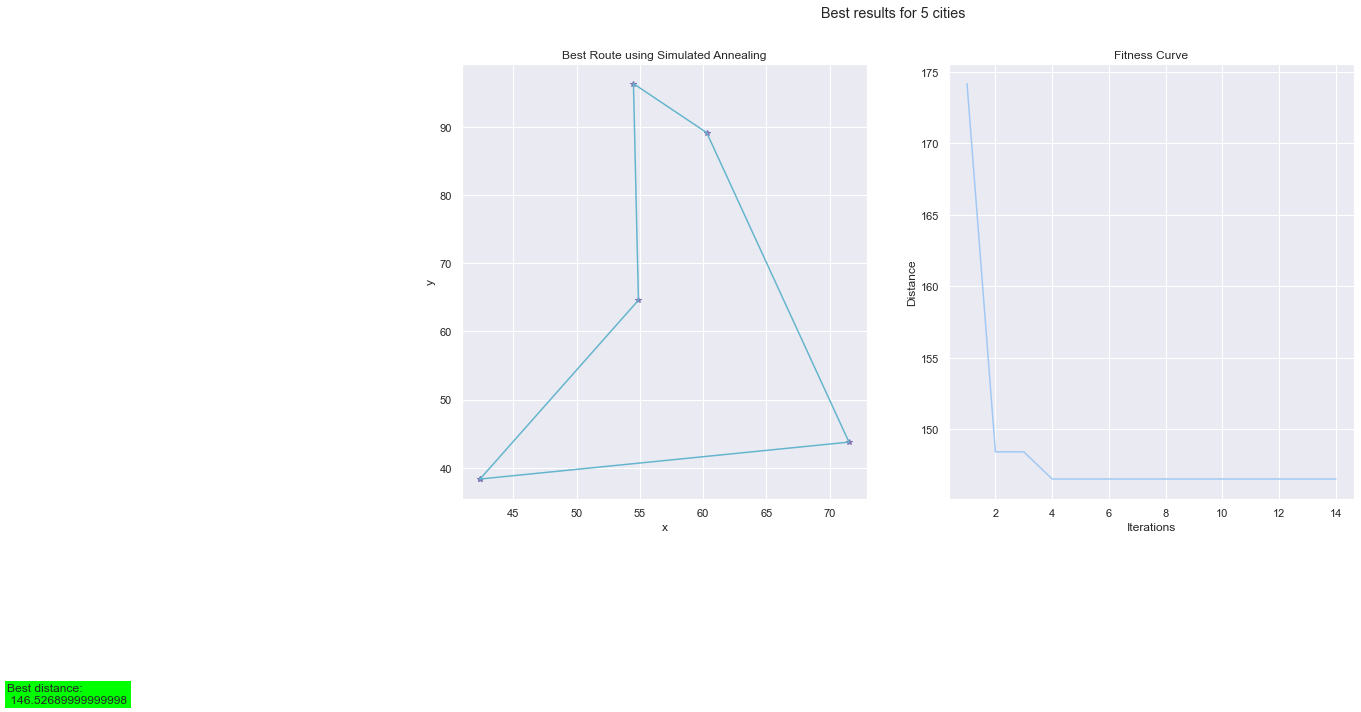

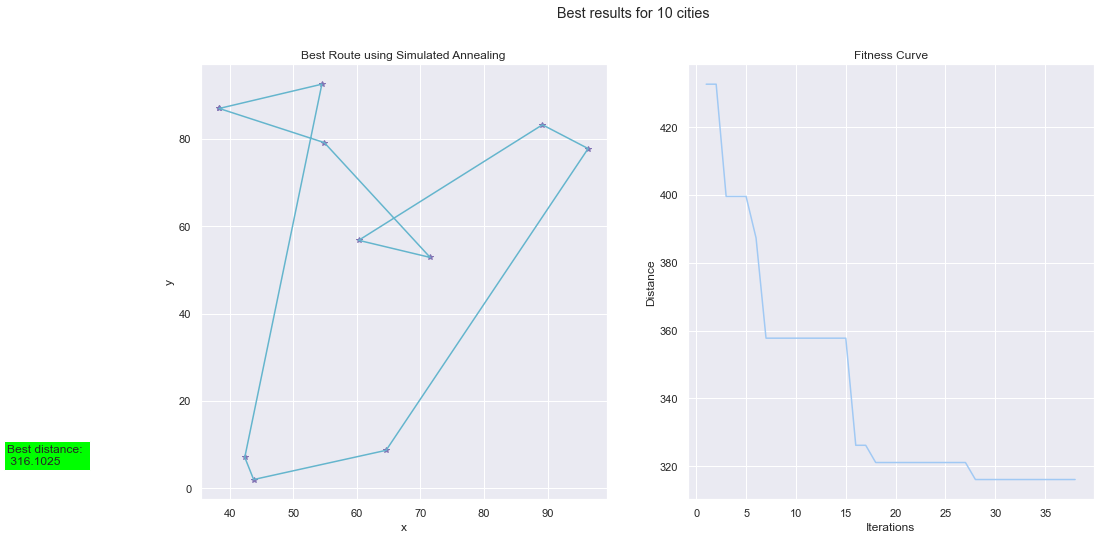

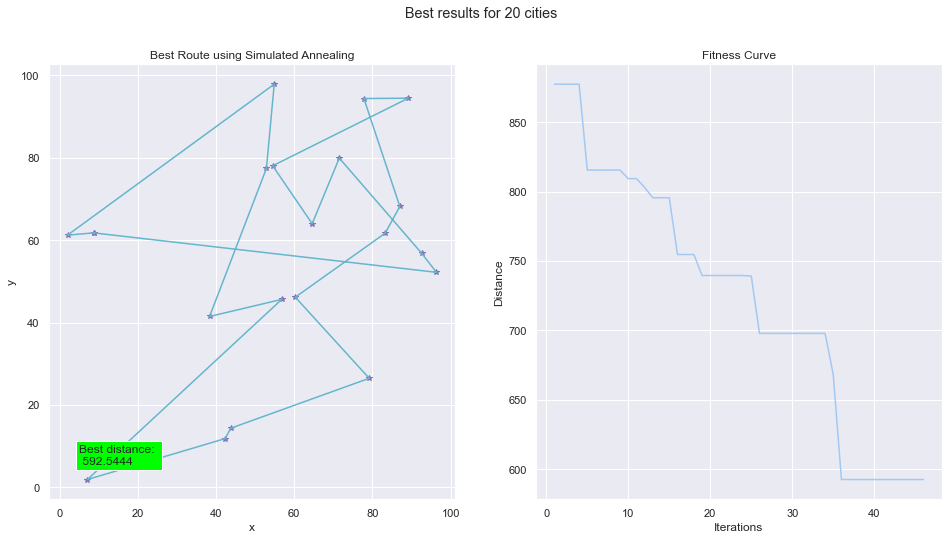

In [4]:
city_sizes = [5, 10, 20]
raw_results, _ = simulate_tsp(city_sizes, 1, show=True)

Show how the algorithm performs on different sizes of cities over a number of simulations:

In [5]:
_, averaged_results = simulate_tsp(city_sizes, 10, show=False)

/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py

### Apply this approach to real world data for 10 cities in South Africa:

In [6]:
za_df, za_results_df, za_averaged_results = simulate_tsp_real_map(10, "../data/za.csv")

/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)
/opt/homebrew/Caskroom/miniforge/base/envs/mlai_tsp/lib/python3.9/site-packages/mlrose/algorithms.py

## Route Optimality

One of the simplistic ways in which one can determine the optimality of the solutions above is by seeing that lines do not cross when conducting the final "optimal" route. The idea is for it to be close to a n sided polygon (not necessarily true in all cases of TSP, but it is a useful guideline). 

## Raw results for varying sizes of cities on the map for every variation tried: 

In [7]:
raw_results

,Nodes,Map,NumIters,DecaySchedule,ProcessingTime,FinalDistance,FitnessCurve,Route
0,5,"[[54.88135039273247, 64.58941130666561], [71.5...",14,a_0001,0.00085,146.5269,"[-174.1575, -148.42649999999998, -148.42649999...","[[42.36547993389047, 38.34415188257777], [71.5..."
1,5,"[[54.88135039273247, 64.58941130666561], [71.5...",10,a_001,0.00061,149.9887,"[-149.9887, -149.9887, -149.9887, -149.9887, -...","[[54.88135039273247, 64.58941130666561], [60.2..."
2,5,"[[54.88135039273247, 64.58941130666561], [71.5...",19,a_01,0.00062,146.5269,"[-171.0301, -171.0301, -171.0301, -171.0301, -...","[[54.88135039273247, 64.58941130666561], [54.4..."
3,5,"[[54.88135039273247, 64.58941130666561], [71.5...",23,g_99,0.00098,146.5269,"[-146.5269, -146.5269, -146.5269, -146.5269, -...","[[71.51893663724195, 43.75872112626925], [42.3..."
4,5,"[[54.88135039273247, 64.58941130666561], [71.5...",14,g_95,0.00097,146.5269,"[-215.6095, -171.0301, -171.0301, -146.5269, -...","[[60.276337607164386, 89.17730007820798], [71...."
5,5,"[[54.88135039273247, 64.58941130666561], [71.5...",21,g_90,0.00127,146.5269,"[-171.0301, -171.0301, -171.0301, -171.0301, -...","[[60.276337607164386, 89.17730007820798], [71...."
6,5,"[[54.88135039273247, 64.58941130666561], [71.5...",28,e_005,0.00110,146.5269,"[-148.4265, -148.4265, -148.4265, -148.4265, -...","[[54.88135039273247, 64.58941130666561], [42.3..."
7,5,"[[54.88135039273247, 64.58941130666561], [71.5...",22,e_01,0.00065,146.5269,"[-149.9887, -148.4265, -148.4265, -148.4265, -...","[[60.276337607164386, 89.17730007820798], [71...."
8,5,"[[54.88135039273247, 64.58941130666561], [71.5...",18,e_05,0.00051,146.5269,"[-149.9887, -149.9887, -149.9887, -148.4265, -...","[[60.276337607164386, 89.17730007820798], [71...."
0,10,"[[54.88135039273247, 79.17250380826646], [71.5...",19,a_0001,0.00183,442.9604,"[-511.66330000000005, -511.66330000000005, -51...","[[96.36627605010293, 77.81567509498505], [54.8..."


## Results averaged for varying sizes of cities on the map: 

In [8]:
averaged_results

NumIters  FinalDistance
Nodes DecaySchedule                          
5     a_0001         12.000000     138.288850
      a_01           10.500000     201.152300
      g_99           10.000000     215.179400
      e_05           13.500000     227.530550
10    a_0001         33.000000     229.873300
5     g_90           11.333333     243.349867
10    g_90           49.000000     276.544150
      e_005          53.000000     287.792500
      g_99           36.000000     290.398300
      e_05           22.000000     310.701300
      a_001          75.000000     316.213400
      g_95           32.000000     336.208400
20    e_05           70.000000     548.896000
      e_005          45.000000     559.539100
      g_95           46.500000     601.511100
      e_01           76.000000     615.923650
      g_99           41.500000     621.248450
      a_0001         58.000000     626.612300
      a_001          30.000000     632.433600

### Impact of number of cities on distance

- It is easy to see visually how the problem becomes significantly more complex as the number of nodes are increased. 
- There are several times in the 20 city scenario that the lines cross where a human can easily see a more optimal solution. 
- There is of course also an increase in the number of iterations required to find the optimal solution and consequently the time as well. 
- Interestingly it appears the arithmetic decay schedule worked well on 5 nodes, a combination of arithmetic as first and geomtric as second for 10 nodes. But, the exponential decay schedule performed much better on 20 nodes. This can provide insight into which schedules to further hone in on and which values of r to zoom into for further refinement. 

### Impact of changing temperature on iterations

- It is challenging to draw too many conclusions of the impact of the rate of change as it may require more thorough experimentation with a larger set of cities and more incremental changes to the r value. 
- However, for the geomtric sequence, from the raw data, it can be seen that as the number of cities are increased a decrease in the schedule allows for better solutions which makes sense as higher values of r will be too slow and potentiall noisy.

### Impact of changing temperature on distance

- The ratio between the best and worst schedules used for 5 cities shows an improvement of 76 %.
- The ratio between the best and worst schedules used for 10 cities shows an improvement of 46 %.
- The ratio between the best and worst schedules used for 20 cities shows an improvement of 15 %.

## Results for Simulated Annealing applied to TSP for 10 South African cities: 

In [9]:
za_results_df

,Nodes,Map,NumIters,DecaySchedule,ProcessingTime,FinalDistance,FitnessCurve,Route
0,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",13,a_0001,0.00111,3714.1758,"[-4751.845700000001, -4467.6111, -3714.1758, -...","[[-29.8583, 31.025], [-33.0153, 27.9116], [-33..."
1,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",32,a_001,0.00235,3816.9184,"[-4504.407299999999, -4489.5900999999985, -441...","[[-26.0936, 28.0064], [-26.1625, 27.8725], [-2..."
2,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",24,a_01,0.00199,3793.4217,"[-5550.7035, -5538.3199, -5171.6531, -5171.653...","[[-26.0936, 28.0064], [-26.6736, 27.9319], [-2..."
3,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",20,g_99,0.00150,4404.9837,"[-4623.8833, -4493.503900000001, -4492.1294000...","[[-26.0936, 28.0064], [-33.0153, 27.9116], [-2..."
4,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",40,g_95,0.00335,3654.6041,"[-5040.3327, -5040.3327, -4756.402099999999, -...","[[-26.2044, 28.0416], [-25.7464, 28.1881], [-2..."
5,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",19,g_90,0.00158,3837.6522,"[-5030.1534, -4657.3122, -4657.3122, -4657.806...","[[-26.1625, 27.8725], [-26.6736, 27.9319], [-2..."
6,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",76,e_005,0.00593,3241.9906,"[-5408.743, -5408.743, -4521.5536, -4521.5536,...","[[-29.5833, 30.4167], [-26.6736, 27.9319], [-2..."
7,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",25,e_01,0.00216,3933.9100,"[-4753.0765, -4753.0765, -4072.3583, -4072.358...","[[-26.6736, 27.9319], [-33.0153, 27.9116], [-3..."
8,10,"[[-26.2044, 28.0416], [-26.6736, 27.9319], [-2...",37,e_05,0.00314,3251.0490,"[-6071.045700000001, -6063.7765, -5667.2066000...","[[-26.6736, 27.9319], [-26.1625, 27.8725], [-2..."


In [10]:
za_averaged_results

NumIters  FinalDistance
Nodes DecaySchedule                          
10    e_05           34.000000    3246.621200
      e_005          62.000000    3248.830850
      a_001          38.500000    3248.908100
      g_99           23.000000    3252.899300
      a_01           44.000000    3315.297200
      e_01           35.666667    3383.040467

## Plot of optimal solution for 10 South African cities: 

In [11]:
route_df, coords_loop = get_best_route(za_df, za_results_df, best_decay_schedule='e_05')
m = plot_real_map_route(route_df, coords_loop)
m

The results found for the cities in South Africa appear to be quite decent as there is no overlap found and route appears to make logical sense albeit, it does not follow the roads but rather straight-line distances.